# ResNet 기반 Citrus_leaves 분류(4 classes)

## Citrus_leaves 다운로드

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from keras import layers

test_set_raw, valid_set_raw, train_set_raw = tfds.load("citrus_leaves", as_supervised=True, split=["train[:10%]", "train[10%:25%]", "train[25%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/0.1.2.incompleteTEWWZL/citrus_leaves-train.tfrecord*...:   0…

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


## 이미지 전처리

In [2]:
# Processing
def preprocess(image, label):
  resized_image = tf.image.resize(image, [256, 256])
  final_image = tf.keras.applications.resnet50.preprocess_input(resized_image)
  return final_image, label

batch_size = 32

train_set = train_set_raw.shuffle(1000).repeat()
valid_set = valid_set_raw.shuffle(1000).repeat()

train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)


**저장된 이미지 확인**

Target: tf.Tensor(0, shape=(), dtype=int64)


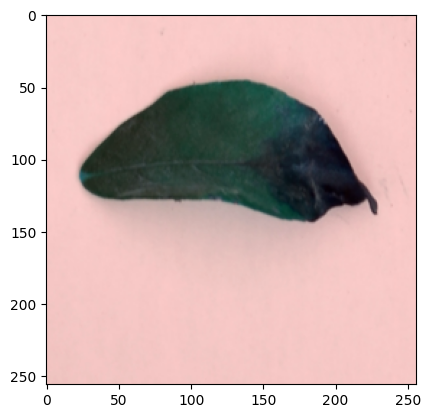

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in train_set:
    plt.imshow(array_to_img(data_batch[0]))
    print("Target:", labels_batch[0])   # 감귤 잎
    break

## Fine Tuning 미적용

In [9]:
# Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**모델 생성**

In [10]:
# ResNet50
base_model= tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
base_model.trainable = False

input = keras.Input(shape = (256, 256, 3))
x = data_augmentation(input)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)

avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(4, activation="softmax")(avg)

model = keras.models.Model(inputs=input, outputs=output)

94765736/94765736 [==============================] - 6s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

**모델 학습**

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Callbacks - CheckPoint
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "citrus_leaves.keras",
        save_best_only = True,
        monitor="val_loss"
    )
]

history = model.fit(train_set, validation_data=valid_set,

                    steps_per_epoch=int(0.75 * 594 / batch_size),
                    validation_steps=int(0.15 * 594 / batch_size),
                    epochs=20,
                    callbacks = callback_list)

**그래프**

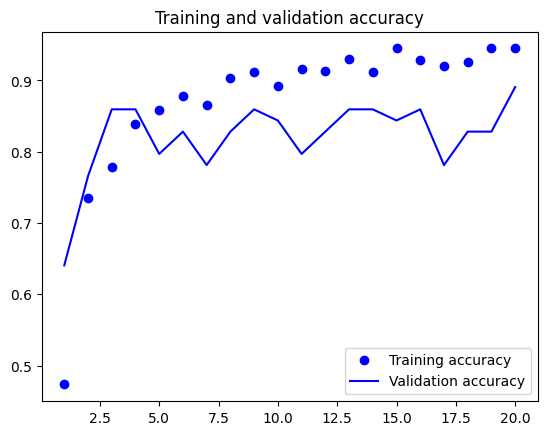

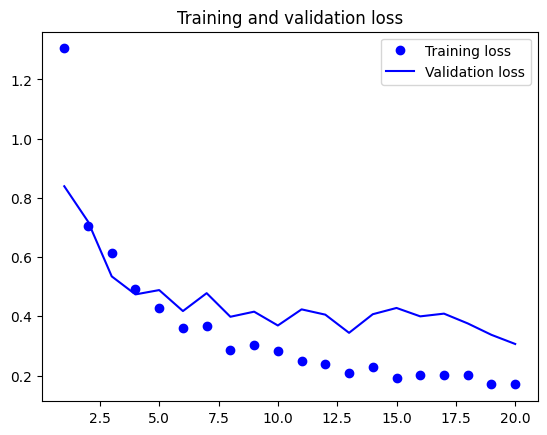

In [ ]:
import matplotlib.pyplot as plt

# 학습 그래프
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

**성능 측정**

In [ ]:
# Checkpoint 불러오기
test_model = keras.models.load_model("citrus_leaves.keras")

# 평가
test_loss, test_acc = test_model.evaluate(test_set)
print(f"손실:{test_loss:.3f}")
print(f"정확도:{test_acc:.3f}")


2/2 [==============================] - 1s 104ms/step - loss: 0.3664 - accuracy: 0.8814
손실:0.366
정확도:0.881


## Fine Tuning 적용

**ConvNet - ResNet 사용 (4계층 학습)**

In [28]:
base_model= tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_11[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [29]:
# Fine_tuning
for layer in base_model.layers[-4:]:
  layer.trainable = True

# Batch 제외
base_model.layers[-3].trainable = False

**모델 생성**

In [31]:
# ResNet50
input = keras.Input(shape = (256, 256, 3))
x = data_augmentation(input)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x)

avg = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(4, activation="softmax")(avg)

model = keras.models.Model(inputs=input, outputs=output)

**모델 학습**

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Callbacks - CheckPoint
callbacks = [
    # earlystopping
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 4
    ),

    # checkpoint
    keras.callbacks.ModelCheckpoint(
        filepath = "fine_tuning2.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(train_set,
                    epochs=20,
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * 594 / batch_size),
                    validation_steps=int(0.15 * 594 / batch_size),
                    callbacks = callbacks)

Epoch 1/20
13/13 [==============================] - 49s 631ms/step - loss: 2.7465 - accuracy: 0.5865 - val_loss: 957.6201 - val_accuracy: 0.2656
Epoch 2/20
13/13 [==============================] - 8s 620ms/step - loss: 0.4775 - accuracy: 0.8462 - val_loss: 346.3471 - val_accuracy: 0.1562
Epoch 3/20
13/13 [==============================] - 7s 528ms/step - loss: 0.4582 - accuracy: 0.8486 - val_loss: 50.7246 - val_accuracy: 0.0625
Epoch 4/20
13/13 [==============================] - 6s 476ms/step - loss: 0.3325 - accuracy: 0.8846 - val_loss: 89.0339 - val_accuracy: 0.2031
Epoch 5/20
13/13 [==============================] - 7s 542ms/step - loss: 0.3542 - accuracy: 0.8918 - val_loss: 4.3802 - val_accuracy: 0.4844
Epoch 6/20
13/13 [==============================] - 6s 478ms/step - loss: 0.3520 - accuracy: 0.8822 - val_loss: 338.2180 - val_accuracy: 0.2031
Epoch 7/20
13/13 [==============================] - 6s 448ms/step - loss: 0.2632 - accuracy: 0.9111 - val_loss: 947.5246 - val_accuracy: 0.

**그래프**

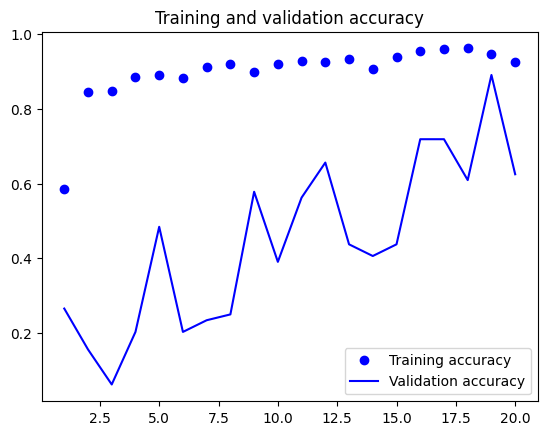

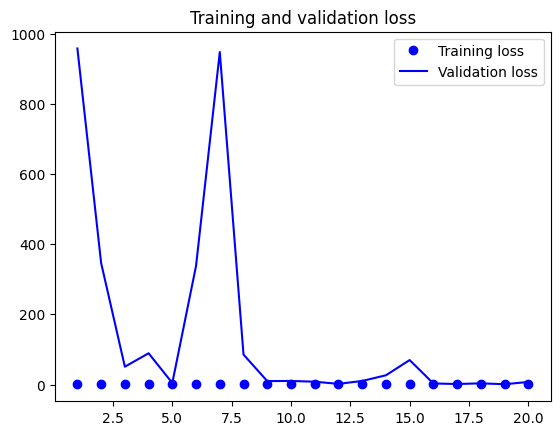

In [33]:
import matplotlib.pyplot as plt

# 학습 그래프
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

**성능 측정**

In [38]:
# Checkpoint 불러오기
test_model = keras.models.load_model("fine_tuning2.keras")

# 평가
test_loss, test_acc = test_model.evaluate(test_set)
print(f"손실:{test_loss:.3f}")
print(f"정확도:{test_acc:.3f}")


2/2 [==============================] - 1s 134ms/step - loss: 1.6254 - accuracy: 0.7966
손실:1.625
정확도:0.797


## 새로운 이미지 예측

해당 잎 정답 Class:: tf.Tensor(1, shape=(), dtype=int64)
1/1 [==============================] - 0s 62ms/step
해당 잎 예측 Class: 1


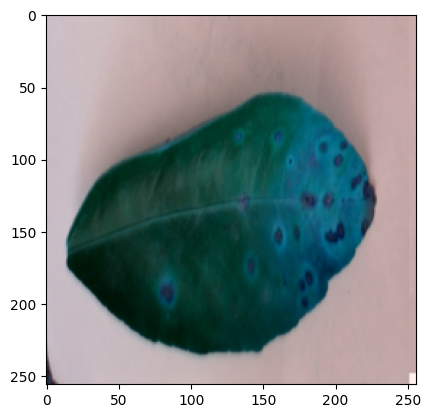

In [41]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import array_to_img


for data_batch, labels_batch in test_set:
    plt.imshow(array_to_img(data_batch[0]))
    print("해당 잎 정답 Class::", labels_batch[0])   # 4개의 Class

    prediction = test_model.predict(data_batch)
    print("해당 잎 예측 Class:", prediction[0].argmax())   # 4개의 Class
    break